In [1]:
import warnings
import numbers
import numpy as np
from scipy import sparse
from math import sqrt
from sklearn.metrics import pairwise_distances_argmin, euclidean_distances
from sklearn.base import TransformerMixin, ClusterMixin, BaseEstimator
from sklearn.utils import check_array
from sklearn.utils.extmath import row_norms
from sklearn.utils.validation import check_is_fitted, _deprecate_positional_args
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.colors as colors
from itertools import cycle
from time import time
from textwrap import dedent
from sklearn.exceptions import NotFittedError
from itertools import chain
from collections import deque, OrderedDict

In [2]:
# пишем функцию _iterate_sparse_X для 
# итерирования по разреженной матрице
def _iterate_sparse_X(X):
    """ возвращает плотное представление строки при итерировании по
    разреженной матрице вместо построения разреженной матрицы для
    каждой строки, что вычислительно дорого.
    """
    # получаем количество строк матрицы
    n_samples = X.shape[0]
    # получаем индексы столбцов с данными по порядку заполнения от нулевой строки
    X_indices = X.indices
    # получаем массив с данными
    X_data = X.data
    # получаем индексы строк, где записаны данные
    X_indptr = X.indptr
    # цикл по строкам
    for i in range(n_samples):
        # создаем нулевую строку размерности количества столбцов матрицы X
        row = np.zeros(X.shape[1])
        # получаем индексы элементов для i-той строки
        startptr, endptr = X_indptr[i], X_indptr[i + 1]
        # получаем индексы столбцов где есть данные в матрице
        nonzero_indices = X_indices[startptr:endptr]
        # в нулевой массив(строку) записываем элементы матрицы
        row[nonzero_indices] = X_data[startptr:endptr]
        # создаем генератор и возвращаем "плотную" строку матрицы
        yield row

In [3]:
# пишем функцию _split_node для 
# разбиения узла
def _split_node(node, threshold, branching_factor):
    """Узел должен быть разбит, если в нем нет места для нового CF-подкластера.
    1. Инициализируем два пустых узла и два пустых CF-подкластера.
    2. Находим пару удаленных друг от друга CF-подкластеров.
    3. Свойства пустых CF-подкластеров и узлов обновляются согласно ближайшему
    расстоянию между CF-подкластерами и парой удаленных CF-подкластеров.
    4. Два узла задаются как потомки для двух CF-подкластеров.
    """
    # инициализируем два пустых CF-подкластера
    new_subcluster1 = _CFSubcluster()
    new_subcluster2 = _CFSubcluster()
    # инициализируем два пустых узла с заданными параметрами и гиперппараметрами
    new_node1 = _CFNode(
        threshold=threshold, branching_factor=branching_factor,
        is_leaf=node.is_leaf,
        n_features=node.n_features)
    new_node2 = _CFNode(
        threshold=threshold, branching_factor=branching_factor,
        is_leaf=node.is_leaf,
        n_features=node.n_features)
    # каждому CF-подкластеру в качестве потомка 
    # назначается новый пустой узел
    new_subcluster1.child_ = new_node1 
    new_subcluster2.child_ = new_node2
    
    # проверяем, является ли входной узел листом (узлом без потомков), 
    # чтобы получить конечные CF-подкластеры
    if node.is_leaf:
        # если входной узел имеет родителя
        if node.prev_leaf_ is not None:
            # для родителя входного узла создаем новый узел и записываем туда новый пустой узел
            node.prev_leaf_.next_leaf_ = new_node1
        # назначаем общего родителя (с входным узлом) для нового узла
        new_node1.prev_leaf_ = node.prev_leaf_
        # для узла new_node1 в качестве потомка назначаем пустой узел new_node2
        new_node1.next_leaf_ = new_node2
        # в качестве родителя узла new_node2  назначаем узел new_node1
        new_node2.prev_leaf_ = new_node1
        # назначаем общего потомка для узла new_node2 и входного узла node
        new_node2.next_leaf_ = node.next_leaf_
        # если входной узел имеет потомков
        if node.next_leaf_ is not None:
            # назначаем для всех потомков входного узла node родителя new_node2
            node.next_leaf_.prev_leaf_ = new_node2
            
    # вычисляем матрицу расстояний между центроидами входного узла и 
    # вектором квадратных норм CF-подкластеров, возвращаем квадрат
    # евклидова расстояния (поскольку squared=True)
    dist = euclidean_distances(
        node.centroids_, Y_norm_squared=node.squared_norm_, squared=True)
    # вычисляем количество кластеров
    n_clusters = dist.shape[0]
    # находим индексы строк двух самых дальних CF-подкластеров из матрицы расстояний
    # dist.argmax() - находит индекс с самым большим значением элемента матрицы
    # np.unravel_index - переводит индекс элемента (число) в индекс матрицы (i, j) 
    # для заданной размерности, таким образом, в farthest_idx будут записаны
    # индексы строк, где находится максимальный элемент dist.argmax()
    farthest_idx = np.unravel_index(
        dist.argmax(), (n_clusters, n_clusters))
    # получаем из матрицы расстояний два вектора расстояний между CF-подкластерами
    node1_dist, node2_dist = dist[(farthest_idx,)] 

    # записываем расстояния между CF-подкластерами в булев массив 
    # (True, если node1_dist < node2_dist)
    node1_closer = node1_dist < node2_dist
    
    # проходим циклом по CF-подкластерам входного узла
    for idx, subcluster in enumerate(node.subclusters_):
        # если node1_dist < node2_dist
        if node1_closer[idx]: 
            # добавляем CF-подкластер из входного узла в новый узел new_node1
            new_node1.append_subcluster(subcluster)
            # обновляем подкластер
            new_subcluster1.update(subcluster)
        # если node1_dist > node2_dist
        else:
            # добавляем CF-подкластер из входного узла в новый узел new_node2
            new_node2.append_subcluster(subcluster)
            # обновляем подкластер
            new_subcluster2.update(subcluster)
    # возвращаем два новых CF-подкластера
    return new_subcluster1, new_subcluster2

In [4]:
# класс для построения CF-дерева
class _CFNode:    
    """
    Каждый узел CF-дерева (CFTree) называется CF-узлом (CFNode).
    
    Параметры
    ----------
    threshold : float
       Порог, необходимый для того, чтобы новый подкластер вошел в CF-подкластер (CFSubcluster).

    branching_factor : int
        Максимальное количество CF-подкластеров в каждом узле.

    is_leaf : bool
        Мы должны знать, является ли CF-узел (CFNode) листом или нет, 
        чтобы получить конечные подкластеры.

    n_features : int
        Количество признаков.

   Атрибуты
    ----------
    subclusters_ : list
        Список подкластеров для конкретного CF-узла.

    prev_leaf_ : _CFNode
        используем только, если is_leaf равно True.

    next_leaf_ : _CFNode
        next_leaf. используем только, если is_leaf is True.
        итоговые подкластеры.

    init_centroids_ : n-мерный массив формы (branching_factor + 1, n_features)
        используем везде ``init_centroids_`` вместо centroids_, поскольку
        centroids - это просто представление ``init_centroids_`` .

    init_sq_norm_ : n-мерный массив формы (branching_factor + 1,)
        используем везде init_sq_norm_, аналогично с ``init_centroids_``.

    centroids_ : n-мерный массив формы (branching_factor + 1, n_features)
        Представление ``init_centroids_``.

    squared_norm_ : n-мерный массив формы (branching_factor + 1,)
        Представление ``init_sq_norm_``.

    """

    def __init__(self, *, threshold, branching_factor, is_leaf, n_features, verbose=False):
        # порог вхождения нового подкластера в подкластер CFSubcluster
        self.threshold = threshold
        # максимальное количество CF-подкластеров в каждом узле
        self.branching_factor = branching_factor
        # флаг является ли узел листом(узлом не имеющим потомков)
        self.is_leaf = is_leaf
        # количество признаков
        self.n_features = n_features
        # подробный вывод алгоритма
        self.verbose = verbose

        # список CF-подкластеров
        self.subclusters_ = []
        # инициализация нулевой матрицы центроидов
        self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
        # инициализация нулевого вектора квадратной нормы
        self.init_sq_norm_ = np.zeros((branching_factor + 1))
        # список квадратных норм
        self.squared_norm_ = []
        # родитель узла
        self.prev_leaf_ = None
        # потомок узла
        self.next_leaf_ = None

    # функция вставки CF-подкластера
    def append_subcluster(self, subcluster):
        # количество CF-подкластеров
        n_samples = len(self.subclusters_)
        # добавляем CF-подкластер в список CF-подкластеров
        self.subclusters_.append(subcluster)
        # записываем в матрицу центроидов значение центроида CF-подкластера(строку)
        self.init_centroids_[n_samples] = subcluster.centroid_
        # записываем в вектор квадратных норм, значение нормы CF-подкластера
        self.init_sq_norm_[n_samples] = subcluster.sq_norm_

        # сохраняем центроид и квадрат нормы для значения + 1
        self.centroids_ = self.init_centroids_[:n_samples + 1, :]
        self.squared_norm_ = self.init_sq_norm_[:n_samples + 1]

        if self.verbose:
            print(f'вставляем CF-подкластер в список CF-подкластеров, количество CF-подкластеров = {n_samples}')
            print(f'центроид  CF-подкластера = {subcluster.centroid_}')
            print(f'сумма квадратов наблюдений CF-подкластера = {subcluster.sq_norm_}')
            print(f'список центроидов CF-подкластеров:\n{self.centroids_}')
            print(f'список квадратных норм CF-подкластеров = {self.squared_norm_}')

    def update_split_subclusters(self, subcluster,
                                 new_subcluster1, new_subcluster2):
        '''
        Удаление CF-подкластера из узла и его обновление с помощью
        разделения CF-подкластеров.
        '''
        # получаем индекс CF-подкластера
        ind = self.subclusters_.index(subcluster)
        # назначаем новый CF-подкластер на место старого CF-подкластера
        self.subclusters_[ind] = new_subcluster1
        # перезаписываем значение нового центроида
        self.init_centroids_[ind] = new_subcluster1.centroid_
        # перезаписываем новое значение квадрата нормы
        self.init_sq_norm_[ind] = new_subcluster1.sq_norm_
        # добавляем новый CF-подкластер
        self.append_subcluster(new_subcluster2)

    def insert_cf_subcluster(self, subcluster):
        '''Вставка нового CF-подкластера в узел'''
        # если список CF-подкластеров пуст
        if not self.subclusters_:
            if self.verbose:
                print('список CF-подкластеров пуст, добавляем новый CF-подкластер')
            # добавляем новый CF-подкластер
            self.append_subcluster(subcluster)
            return False
        # порог
        threshold = self.threshold
        # максимальное количество CF-подкластеров в узле
        branching_factor = self.branching_factor
        # нам нужно найти ближайший CF-подкластер среди всех CF-подкластеров, 
        # чтобы мы могли вставить новый CF-подкластер
        # получаем матрицу расстояний как произведение матрицы центроидов CF-подкластеров
        # на вектор центроида CF-подкластера
        dist_matrix = np.dot(self.centroids_, subcluster.centroid_)
        dist_matrix *= -2.
        # прибавляем квадратную норму
        dist_matrix += self.squared_norm_
        # выбираем индекс элемента с наименьшим значением
        closest_index = np.argmin(dist_matrix)
        # записываем CF-подкластер
        closest_subcluster = self.subclusters_[closest_index]

        if self.verbose:
            print(f'матрица расстояний от заданного CF-подкластера ко всем CF-подкластерам = {dist_matrix}')
            print(f'индекс ближайшего к CF-подкластеру CF-подкластера, с наименьшим расстоянием = {closest_index}')


        # если у CF-подкластера есть потомки, то нужна рекурсия
        # если у CF-подкластера есть потомки
        if closest_subcluster.child_ is not None:
            # к потомку CF-подкластера вставляем новый CF-подкластер в узел
            split_child = closest_subcluster.child_.insert_cf_subcluster(
                subcluster)
            # если не удалось вставить новый CF-подкластер в узел
            if not split_child:
                # если определено, что потомок не может быть разделен,
                # мы можем просто обновить ближайший CF-подкластер
                closest_subcluster.update(subcluster)
                # обновляем центроид CF-подкластера
                self.init_centroids_[closest_index] = \
                    self.subclusters_[closest_index].centroid_
                # обновляем квадратную норму CF-подкластера
                self.init_sq_norm_[closest_index] = \
                    self.subclusters_[closest_index].sq_norm_
                # возвращаем False
                return False
       
            # нам нужно перераспределить CF-подкластеры в нашем дочернем узле 
            # и добавить новый CF-подкластер в родительский CF-подкластер, чтобы 
            # разместить новый дочерний узел
            else:
                # разбивает CF-подкластер на два новых
                new_subcluster1, new_subcluster2 = _split_node(
                    closest_subcluster.child_, threshold, branching_factor)
                # удаляем CF-подкластер closest_subcluster из узла и обновляем, добавляя два новых
                self.update_split_subclusters(
                    closest_subcluster, new_subcluster1, new_subcluster2)
                # если количество CF-подкластеров не превышает допустимое
                if len(self.subclusters_) > self.branching_factor:
                    # возвращаем True
                    return True
                # возвращаем False
                return False

        else:
            # объединяем CF-подкластеры по пороговому значению
            merged = closest_subcluster.merge_subcluster(
                subcluster, self.threshold)

            # если объединение возможно
            if merged:
                # перезаписываем новый центроид
                self.init_centroids_[closest_index] = \
                    closest_subcluster.centroid_
                # перезаписываем новую квадратную норму
                self.init_sq_norm_[closest_index] = \
                    closest_subcluster.sq_norm_
                if self.verbose:
                    print(f'новый список центроидов:\n{self.init_centroids_}')
                    print(f'новый список квадратных норм = {self.init_sq_norm_}')
                # возвращаем False
                return False

            # если количество CF-подкластеров меньше максимального допустимого значения,
            # то добавляем еще CF-подкластер
            elif len(self.subclusters_) < self.branching_factor:
                if self.verbose:
                    print(f'количество CF-подкластеров = {len(self.subclusters_)} меньше максимального допустимого '
                          f'значения = {self.branching_factor}, добавляем новый CF-подкластер')
                # вставляем CF-подкластер
                self.append_subcluster(subcluster)
                # возвращаем False
                return False

            # если у нас недостаточно места и мы также не близко к другому CF-подкластеру
            # нам нужно разделиться
            else:
                if self.verbose:
                    print(f'количество CF-подкластеров, больше максимально допустимого')
                    print(f'CF-подкластер нужно разделить')
                # вставляем подкластер
                self.append_subcluster(subcluster)
                # возвращаем True
                return True

In [5]:
class _CFSubcluster:
    """
    Каждый подкластер в CFNode называется CFSubcluster.
    Подкластер(CFSubcluster) может иметь CFNode в качестве потомка.
    
    Параметры
    --------------
    linear_sum : ndarray of shape (n_features,), default=None
        Необязателен, чтобы разрешить инициализацию пустых подкластеров.
    
    Аттрибуты
    ---------
    n_samples_ : int
        Количество наблюдений, принадлежащих каждому подкластеру.

    linear_sum_ : ndarray
        Линейная сумма всех наблюдений в подкластере. 
        Предотвращает удержание всех наблюдений в памяти.

    squared_sum_ : float
        Сумма квадратов всех наблюдений, принадлежащих подкластеру.

    centroid_ : ndarray of shape (branching_factor + 1, n_features)
    Центроид подкластера. Предотвращает повторный расчет центроидов, 
    когда вызывается ``CFNode.centroids_``

    child_ : _CFNode
        Потомок подкластера. Как только данный _CFNode становится потомком _CFNode,
        ему присваивается значение ``self.child_``.

    sq_norm_ : ndarray of shape (branching_factor + 1,)
        Квадратная норма подкластера. 
        Предотвращает повторное вычисление попарных минимальных расстояний.
    """

    def __init__(self, *, linear_sum=None, samples_id=None, verbose=False):
        # если линейная сумма равна None
        if linear_sum is None:
            # количество наблюдений (строк матрицы данных)
            self.n_samples_ = 0
            # сумма квадратов наблюдений
            self.squared_sum_ = 0.0
            # центроид CF-подкластера равен линейной сумме наблюдений
            self.centroid_ = self.linear_sum_ = 0
            self.samples_id_ = deque()
        else:
            # если задана линейная сумма
            # количество строк матрицы данных = 1
            self.n_samples_ = 1
            # центроид CF-подкластера равен линейной сумме наблюдений
            self.centroid_ = self.linear_sum_ = linear_sum
            # квадратная сумма наблюдений
            self.squared_sum_ = self.sq_norm_ = np.dot(
                self.linear_sum_, self.linear_sum_)
            if samples_id is not None:
                self.samples_id_ = deque(samples_id)
            else:
                self.samples_id_ = None
        # инициализируется переменная для потомка
        self.child_ = None
        # комментирование хода обучения
        self.verbose = verbose

    # функция обновления CF-подкластера
    def update(self, subcluster):
        # добавляем количество наблюдений
        self.n_samples_ += subcluster.n_samples_
        # добавляем количество линейных сумм
        self.linear_sum_ += subcluster.linear_sum_
        # добавляем квадратные суммы
        self.squared_sum_ += subcluster.squared_sum_
        # вычисляем центроид
        self.centroid_ = self.linear_sum_ / self.n_samples_
        # вычисляем квадратную норму CF-подкластера как 
        # произведение вектора центроида на себя
        self.sq_norm_ = np.dot(self.centroid_, self.centroid_)
        if self.samples_id_ is None or subcluster.samples_id_ is None:
            self.samples_id_ = None
        else:
            self.samples_id_.extend(subcluster.samples_id_)

    # метод .merge_subcluster() выполняет слияние CF-подкластеров 
    # в соответствии с порогом
    def merge_subcluster(self, nominee_cluster, threshold):
        """Проверяем, подходит ли кластер для слияния. Если
         да, тогда выполняем слияние.
        """
        # вычисляем новую сумму квадратов наблюдений
        new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
        # вычисляем новую линейную сумму наблюдений
        new_ls = self.linear_sum_ + nominee_cluster.linear_sum_
        # вычисляем новое количество наблюдений
        new_n = self.n_samples_ + nominee_cluster.n_samples_
        # вычисляем новый центроид
        new_centroid = (1 / new_n) * new_ls
        # вычисляем норму центроида
        new_norm = np.dot(new_centroid, new_centroid)
        # вычисляем скалярное произведение которое будет использоваться в
        # формуле вычисления радиуса кластерного элемента
        dot_product = (-2 * new_n) * new_norm
        # вычисляем радиус кластерного элемента
        sq_radius = (new_ss + dot_product) / new_n + new_norm
        
        # сравниваем с пороговым значением, так как должен быть квадратный
        # корень от радиуса, то возводим порог в квадрат 
        # если радиус меньше или равен порогу в квадрате, задаем новые 
        # значения для n, ls, ss, centroid и norm
        if sq_radius <= threshold ** 2:
            if self.verbose:
                print(f'радиус кластерного элемента R = {sq_radius}, <= {threshold}**2 пороговому значению')
                print('объединяем подкластеры по пороговому значению')
                print(f'сумма квадратов наблюдений данных SS = {new_ss}')
                print(f'линейная сумма LS = {new_ls}')
                print(f'количество наблюдений N = {new_n}')
                print(f'новый центроид после объединения = {new_centroid}')
                print(f'норма нового центроида = {new_norm}')
            # задаем новые значения для размера наблюдений, линейной суммы,
            # центроида, суммы квадратов, и нормы
            if self.samples_id_ is None or nominee_cluster.samples_id_ is None:
                self.samples_id_ = None
            else:
                self.samples_id_.extend(nominee_cluster.samples_id_)
            (self.n_samples_, self.linear_sum_, self.squared_sum_,
             self.centroid_, self.sq_norm_) = \
                new_n, new_ls, new_ss, new_centroid, new_norm
            # возвращаем True
            return True
        # возвращаем False
        return False

    # функция расчета радиуса CF-подкластера https://en.wikipedia.org/wiki/BIRCH
    @property
    def radius(self):
        '''
        Возвращает радиус CF-подкластера R = sqrt((N*vC^2 + SS - 2*vC*vLS)/N)
        здесь используется формула записаная иначе: R = sqrt((SS-2*vC*vLS)/N + vC^2)
        '''
        dot_product = -2 * np.dot(self.linear_sum_, self.centroid_)
        return sqrt(
            ((self.squared_sum_ + dot_product) / self.n_samples_) +
            self.sq_norm_)

In [6]:
# класс кластеризации BIRCH
class Birch(ClusterMixin, TransformerMixin, BaseEstimator):
    """
    Параметры
    ------------
    threshold : float, default=0.5
        Радиус CF-подкластера, полученный путем слияния нового наблюдения и
        ближайшего CF-подкластера, должен быть меньше порогового значения. 
        В противном случае задается новый CF-подкластер. Очень низкие значения
        этого параметра способствуют разбиению и наоборот.
    
    branching_factor : int, default=50
        Максимальное количество CF-подкластеров в каждом узле. Если новые наблюдения 
        поступают так, что количество CF-подкластеров превышает branching_factor, то 
        этот узел разбивается на два узла с перераспределением подкластеров в каждом. 
        Родительский CF-подкластер этого узла удаляется и два новых CF-подкластера добавляются 
        в качестве родителей двух разбитых узлов.
    
    n_clusters : int, instance of sklearn.cluster model, default=3
        Количество кластеров после заключительного этапа кластеризации, который
        рассматривает подкластеры из листьев как новые наблюдения.
        - `None` : заключительный шаг кластеризации не выполняется, и
            CF-подкластеры возвращаются такими, какие они есть.

        - :mod:`sklearn.cluster` Estimator : если задана модель, модель
            обучается, обрабатывая CF-подкластеры как новые наблюдения и
            исходные данные сопоставляются с меткой ближайшего CF-подкластера.
        - `int` : модель обучается с помощью класса `AgglomerativeClustering`
            с `n_clusters`, равным int.
    
    compute_labels : bool, default=True
        Следует ли вычислять метки для каждого прогона.

    copy : bool, default=True
        Следует ли делать копию данных. Если задано значение False, 
        исходные данные будут перезаписаны.
        
    Атрибуты
    -----------------
    root_ : _CFNode
        Корень CFTree.

    dummy_leaf_ : _CFNode
        Начальный указатель на все листья.

    subcluster_centers_ : n-мерный массив
        Центроиды всех CF-подкластеров считываются напрямую из листьев.

    subcluster_labels_ : n-мерный массив
        Метки, присвоенные центроидам CF-подкластеров 
        после того, как они кластеризованы глобально.

    labels_ : n-мерный массив формы (n_samples,)
        Массив меток, присвоенных входным данным. Если partial_fit используется 
        вместо fit, они присваиваются последнему батчу данных.

    Древовидная структура данных состоит из узлов, каждый из которых состоит 
    из нескольких CF-подкластеров. Максимальное количество CF-подкластеров в узле 
    определяется с помощью branching factor. Каждый CF-подкластер содержит линейную 
    сумму, сумму квадратов и количество наблюдений в этом CF-подкластере. Кроме того, 
    у каждого CF-подкластера еще может быть дочерний узел, если CF-подкластер не входит 
    в лист. Новая точка, входящая в корневой узел, объединяется с ближайшим к ней 
    CF-подкластером, и обновляются линейная сумма, сумма квадратов и количество 
    наблюдений этого CF-подкластера. Это делается рекурсивно, пока не будут 
    обновлены свойства листа.
    
    Ссылки
    ----------
    * Tian Zhang, Raghu Ramakrishnan, Maron Livny
      BIRCH: An efficient data clustering method for large databases.
      https://www.cs.sfu.ca/CourseCentral/459/han/papers/zhang96.pdf

    * Roberto Perdisci
      JBirch - Java implementation of BIRCH clustering algorithm
      https://code.google.com/archive/p/jbirch

    Пример
    --------
    >>> from sklearn.cluster import Birch
    >>> X = [[0, 1], [0.3, 1], [-0.3, 1], [0, -1], [0.3, -1], [-0.3, -1]]
    >>> brc = Birch(n_clusters=None)
    >>> brc.fit(X)
    Birch(n_clusters=None)
    >>> brc.predict(X)
    array([0, 0, 0, 1, 1, 1])
    """
    
    @_deprecate_positional_args
    def __init__(self, *, threshold=0.5, branching_factor=50, n_clusters=3,
                 compute_labels=True, copy=True, compute_sample_indices=False, verbose=False):
        # порог
        self.threshold = threshold
        # максимальное количество CF-подкластеров в каждом узле
        self.branching_factor = branching_factor
        # количество кластеров
        self.n_clusters = n_clusters
        # метки кластеров
        self.compute_labels = compute_labels
        # копирование данных
        self.copy = copy
        # комментирование хода обучения
        self.verbose = verbose
        # вычисление индексов наблюдений
        self.compute_sample_indices = compute_sample_indices

    def fit(self, X, y=None):
        """
        Строит CF-дерево по входным данным.

        Параметры
        ----------
        X : {массив, разреженная матрица} формы (n_samples, n_features)
            Входные данные.

        y : Игнорируется
            Не используется, нужен только для совместимости с API.

        Возвращает
        -------
        self
            Обученная модель.
        """
        self.fit_, self.partial_fit_ = True, False
        return self._fit(X)

    # метод _fit() строит CF-дерево
    def _fit(self, X):
        # проверяем данные
        X = self._validate_data(X, accept_sparse='csr', copy=self.copy)
        self.n_samples_ = X.shape[0]
        # пороговое значение
        threshold = self.threshold
        # максимальное количество CF-подкластеров в каждом узле
        branching_factor = self.branching_factor
        # вычисление индексов наблюдений
        compute_sample_indices = self.compute_sample_indices
        # комментирование хода обучения
        verbose = self.verbose

        if verbose:
            print(100*'*')
            print(f'задано пороговое значение = {threshold}')
            print(f'максимальное количество CF-подкластеров в каждом узле = {branching_factor}')
            print(f'заданное количество кластеров = {self.n_clusters}')
            flag_cluster_label = 'Да' if self.compute_labels else 'Нет'
            print(f'вычисление меток кластера = {flag_cluster_label}')

        # максимальное количество CF-подкластеров в каждом узле не может быть меньше 1
        if branching_factor <= 1:
            raise ValueError("Branching_factor should be greater than one.")
        if self.compute_sample_indices and self.partial_fit_:
            raise ValueError("The option compute_sample_indices=True is not "
                             "compatible with out of core calculations. "
                             "Please either set it to False, or dont use the "
                             "partial_fit method.")

        # из матрицы входных данных получаем количество данных и количество признаков(строк, столбцов)
        n_samples, n_features = X.shape

        if verbose:
            print(f'количество наблюдений = {n_samples}, количество признаков = {n_features}')

        # проверяем атрибуты переменной partial_fit (частичного обучения)
        partial_fit = getattr(self, 'partial_fit_')
        # проверяем утрибут переменной root_ , значение по умолчанию равно None
        has_root = getattr(self, 'root_', None)
        # если partial_fit вызывается в первый раз или вызывается fit, мы начинаем новое дерево.
        if getattr(self, 'fit_') or (partial_fit and not has_root):
            if verbose:
                print(100*'-')
                print('создаем корень дерева и пустой указатель')
                print('проходим по каждой строке матрицы даных')
            # создаем корень
            self.root_ = _CFNode(threshold=threshold,
                                 branching_factor=branching_factor,
                                 is_leaf=True,
                                 n_features=n_features,
                                 verbose=verbose)

            # начальный указатель на все листья
            self.dummy_leaf_ = _CFNode(threshold=threshold,
                                       branching_factor=branching_factor,
                                       is_leaf=True, n_features=n_features,
                                       verbose=verbose)
            # присваиваем начальному указателю потомка корень
            self.dummy_leaf_.next_leaf_ = self.root_
            # присваиваем корню родителя начальный указатель
            self.root_.prev_leaf_ = self.dummy_leaf_

        # если матрица не разрежена используем разные итераторы
        if not sparse.issparse(X):
            # обычный итератор
            iter_func = iter
        else:
            # итератор по разреженной матрице
            iter_func = _iterate_sparse_X
            if self.verbose:
                print('исходная матрица является разреженной, будет использован итератор по разреженной матрице')
        k = 0
        # проходим по строкам итератором
        for sample in iter_func(X):
            if compute_sample_indices:
                samples_id = [k]
            else:
                samples_id = None
            if self.verbose:
                print(100*'-')
                print(f'создаем CF-подкластер из {k} строки =  {sample} и вставляем в корень дерева')
            # создаем подкластер
            subcluster = _CFSubcluster(linear_sum=sample, samples_id=samples_id, verbose=self.verbose)
            # вставляем CF-подкластер в корень
            split = self.root_.insert_cf_subcluster(subcluster)
            k += 1

            # если превышено максимальное количество CF-подкластеров в узле
            if split:
                if self.verbose:
                    print('превышено максимальное количество CF-подкластеров в узле')
                # делим узел на два CF-подкластера
                new_subcluster1, new_subcluster2 = _split_node(
                    self.root_, threshold, branching_factor)
                # удаляем корень
                del self.root_
                # создаем новый корень
                self.root_ = _CFNode(threshold=threshold,
                                     branching_factor=branching_factor,
                                     is_leaf=False,
                                     n_features=n_features)
                # вставляем в новый корень CF-подкластеры
                self.root_.append_subcluster(new_subcluster1)
                self.root_.append_subcluster(new_subcluster2)

        # получаем матрицу центроидов
        centroids = np.concatenate([
            leaf.centroids_ for leaf in self._get_leaves()])
        # записываем матрицу центроидов
        self.subcluster_centers_ = centroids
        if self.verbose:
            print(50*'*')
            print(f'матрица центроидов:\n{centroids}')
        # проводим глобальную кластеризацию
        self._global_clustering(X)
        return self
    # функция извлекает листья CF-узла
    def _get_leaves(self):
        """
        Извлекает листья CF-узла.

        Возвращает
        -------
        leaves : список формы (n_leaves,)
            Список листьев.
        """
        print('извлекаем листья CF-узла')
        # записываем в leaf_ptr всех потомков узла
        leaf_ptr = self.dummy_leaf_.next_leaf_
        # список листьев
        leaves = []
        # добавляем всех потомков
        while leaf_ptr is not None:
            print(f'добавляем лист leaf_ptr = {leaf_ptr}')
            # добавляем потомка узла
            leaves.append(leaf_ptr)
            # в leaf_prt записываем потомка текущего листа(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf_
        return leaves

    # метод .partial_fit() осуществляет онлайн-обучение
    def partial_fit(self, X=None, y=None):
        """
        Осуществляет онлайн-обучение. Предотвращает восстановление CF-дерева с нуля.

        Параметры
        ----------
        X : {массив, разреженная матрица} формы (n_samples, n_features), \
            default=None
            Входные данные. Если X не указан, выполняется лишь
            шаг глобальной кластеризации.

        y : Игнорируется
            Не используется, нужен только для совместимости с API.

        Возвращает
        -------
        self
            Обученная модель.
        """
        # назначаем переменным значения
        self.partial_fit_, self.fit_ = True, False
        # если X не задан
        if X is None:
            # выполняем последний шаг, глобальную кластеризацию
            self._global_clustering()
            return self
        else:
            # запускаем функцию проверки построения дерева
            self._check_fit(X)
            # запускаем обучения, построения CF дерева
            return self._fit(X)

    # функция проверки построения дерева
    def _check_fit(self, X):
        # проверяем подходит ли estimator, проверяем наличие атрибутов
        check_is_fitted(self)
        # проверяем наличие у класса атрибута subcluster_centers_ и несовпадение
        # количества признаков(столбцов) матрицы X и количества центров CF-подкластеров
        if (hasattr(self, 'subcluster_centers_') and
                X.shape[1] != self.subcluster_centers_.shape[1]):
            # если у обучающих данных и прогнозируемых данных 
            # разное количество признаков, выдаем ошибку
            raise ValueError(
                "Training data and predicted data do "
                "not have same number of features.")

    # метод .predict() вычисляет прогнозы
    def predict(self, X):
        """
        Прогнозирует данные с помощью ``centroids_`` CF-подкластеров.

        Предотвращает вычисление исходных норм X.

        Параметры
        ----------
        X : {массив, разреженная матрица} формы (n_samples, n_features)
            Входные данные.

        Возвращает
        -------
        labels : n-мерный массив формы (n_samples,)
            Размеченные данные.
        """
        # проверяем входные данные
        X = check_array(X, accept_sparse='csr')
        # проверяем параметры для построение дерева
        self._check_fit(X)
        # задаем норму как норму CF-подкластеров
        kwargs = {'Y_norm_squared': self._subcluster_norms}
        # возвращаем метки подкластеров, вычисляем минимальное расстояние
        # от набора наблюдений X до центров CF-подкластеров используя матрицу квадрата норм
        return self.subcluster_labels_[
            pairwise_distances_argmin(X,
                                      self.subcluster_centers_,
                                      metric_kwargs=kwargs)
        ]

    # метод transform() преобразовывает данные
    def transform(self, X):
        """
        Преобразовывает X в размерность центроидов CF-подкластера.

        Каждая размерность представляет собой расстояние от 
        точки наблюдений до каждого центроида кластера.

        Параметры
        ----------
        X : {массив, разреженная матрица} формы (n_samples, n_features)
            Входные данные.

        Возвращает
        -------
        X_trans : {массив, разреженная матрица} формы (n_samples, n_clusters)
            Преобразованные данные.
        """
        # проверяем подходит ли estimator, проверяем наличие атрибутов
        check_is_fitted(self)
        # расчитываем евклидово расстояние от данных то каждого центроида кластера
        return euclidean_distances(X, self.subcluster_centers_)

    # метод _global_clustering() выполняет глобальную кластеризацию
    def _global_clustering(self, X=None):
        """
        Глобальная кластеризация CF-подкластеров, полученных после обучения
        """
        # количество кластеров
        clusterer = self.n_clusters
        # центроиды кластеров
        centroids = self.subcluster_centers_
        # флаг вычисления меток
        compute_labels = (X is not None) and self.compute_labels

        if self.verbose:
            print(50*'*')
            print(f'кластеризация, количество заданных кластеров = {clusterer}')
            print(f'проводим иерархическую кластеризацию агломеративным методом')
            print('новые кластеры создаются путем объединения более мелких кластеров и,'
                  ' дерево создается от листьев к корню')

        # предварительная обработка для глобальной кластеризации
        not_enough_centroids = False
        # проверяем, что количество кластеров - это целочисленное число
        if isinstance(clusterer, numbers.Integral):
            # агломеративная кластеризация:
            # рекурсивно объединяет пару кластеров
            clusterer = AgglomerativeClustering(n_clusters=self.n_clusters)
            # нет необходимости выполнять шаг глобальной кластеризации,
            # если длина центроидов меньше количества кластеров
            if len(centroids) < self.n_clusters:
                if self.verbose:
                    print('недостаточно центроидов')
                # флаг not_enough_centroids принимает значение True
                not_enough_centroids = True
        # если модель кластеризации не задана или у модели нет атрибута fit_predict
        elif (clusterer is not None and not
        hasattr(clusterer, 'fit_predict')):
            # генерируем ошибку
            raise ValueError("n_clusters should be an instance of "
                             "ClusterMixin or an int")
        # использовать в прогнозе, чтобы избежать повторных вычислений
        self._subcluster_norms = row_norms(
            self.subcluster_centers_, squared=True)

        if self.verbose:
            print(f'Евклидова норма подкластеров = {self._subcluster_norms}')
        # если модель кластеризации не задана или недостаточно центроидов
        if clusterer is None or not_enough_centroids:
            # проставляем метки подкластеров
            self.subcluster_labels_ = np.arange(len(centroids))
            # если недостаточно центроидов
            if not_enough_centroids:
                # Количество подкластеров, найденных Birch ... Уменьшите порог.
                warnings.warn(
                    "Number of subclusters found (%d) by Birch is less "
                    "than (%d). Decrease the threshold."
                    % (len(centroids), self.n_clusters), ConvergenceWarning)
        else:
            # шаг глобальной кластеризации, который кластеризует подкластеры листьев.
            # Он принимает центроиды подкластеров в качестве наблюдений 
            # и находит окончательные центроиды.
            self.subcluster_labels_ = clusterer.fit_predict(
                self.subcluster_centers_)
            if self.verbose:
                print(f'метки подкластеров = {self.subcluster_labels_}')
        # если compute_labels=True
        if compute_labels:
            # вычисляем метки
            self.labels_ = self.predict(X)
            if self.verbose:
                print(f'метки кластеров = {self.labels_}')

Данные перед применением BIRCH


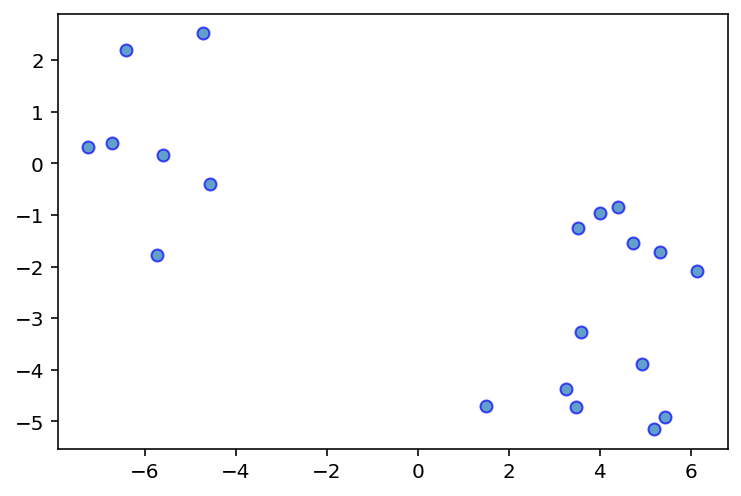

In [7]:
X, y = make_blobs(n_samples=20, centers=3, random_state=123, n_features=2)
print("Данные перед применением BIRCH")
plt.scatter(X[:, 0], X[:, 1], alpha=0.7, edgecolors='b')
plt.show()

In [8]:
X

array([[ 3.25049756, -4.37192227],
       [-5.60303965,  0.16454049],
       [ 3.48540175, -4.71156458],
       [-7.23450403,  0.32641815],
       [ 5.31684183, -1.71150648],
       [-4.55586573, -0.40238532],
       [-4.72560235,  2.51702741],
       [ 4.39222531, -0.84964809],
       [ 4.93343761, -3.8910269 ],
       [ 3.50984305, -1.25424347],
       [-6.3988048 ,  2.20212443],
       [ 1.50270447, -4.70612593],
       [-6.7168516 ,  0.38854388],
       [ 6.13531379, -2.09042721],
       [ 4.72796845, -1.54970129],
       [ 5.42077334, -4.9161153 ],
       [ 5.19531997, -5.1439537 ],
       [-5.7185903 , -1.77229372],
       [ 3.58401288, -3.26554029],
       [ 3.9984796 , -0.96406494]])

In [9]:
# вызов с заданным количеством кластеров
birch_model = Birch(n_clusters=3, threshold=0.7, branching_factor=5,
                    compute_sample_indices=True, verbose=True)
birch_model.fit(X)

****************************************************************************************************
задано пороговое значение = 0.7
максимальное количество CF-подкластеров в каждом узле = 5
заданное количество кластеров = 3
вычисление меток кластера = Да
количество наблюдений = 20, количество признаков = 2
----------------------------------------------------------------------------------------------------
создаем корень дерева и пустой указатель
проходим по каждой строке матрицы даных
----------------------------------------------------------------------------------------------------
создаем CF-подкластер из 0 строки =  [ 3.25049756 -4.37192227] и вставляем в корень дерева
список CF-подкластеров пуст, добавляем новый CF-подкластер
вставляем CF-подкластер в список CF-подкластеров, количество CF-подкластеров = 0
центроид  CF-подкластера = [ 3.25049756 -4.37192227]
сумма квадратов наблюдений CF-подкластера = 29.67943872404873
список центроидов CF-подкластеров:
[[ 3.25049756 -4.37192227]]

Birch(branching_factor=5, compute_sample_indices=True, threshold=0.7,
      verbose=True)

In [10]:
class Container(dict):
    '''
    Класс содержит дерево объектов. Каждый контейнер является 
    подклассом словаря в котором хранится его содержимое.
    
    Аттрибуты:
    children ([Container]): возможно, пустой список дочерних контейнеров.
    parent (Container): родительский контейнер, если есть
    '''
    def __init__(self, **args):
        dict.__init__(self, **args)
        self.parent = None
        self.children = []

    def __repr__(self):
        return '<%s %x: %r>' % (self.__class__.__name__, id(self),
                                dict.__repr__(self))

    def __hash__(self):
        '''
        Функция делает контейнер хешируемым.
        Однако следует проявлять осторожность,
        чтобы не изменить содержимое контейнера после инициализации,
        иначе значение хеш-функции изменится.
        '''
        return hash(tuple(sorted(self.items())) + (self.parent,))

    @property
    def is_dummy(self):
        '''Проверяем, есть ли в контейнере какое-либо содержимое.'''
        return not len(self.keys())

    def add_child(self, child):
        '''
        Добавить ребенка в контейнер
        
        Параметры
        ------------
        child : контейнер
           добавляем ребенка
        '''
        if child.parent:
            child.parent.remove_child(child)
        self.children.append(child)
        child.parent = self

    def remove_child(self, child):
        '''
        Удалить ребенка из контейнера
        
        Параметры
        ------------
        child : Container
           Child to remove.
        '''
        self.children.remove(child)
        child.parent = None

    def has_descendant(self, ctr):
        '''
        Проверяем, является ли ctr потомком этого контейнера.
        Parameters
        ----------
        ctr : Container
           возможный дочерний контейнер.

        Returns
        -------
        True if `ctr` is a descendant of `self`, else False.
        
        '''
        # Чтобы избежать бесконечного повторения,
        # мы выполним поиск в глубину; «seen» отслеживает контейнеры,
        # которые мы уже видели, а «stack» - это двухсторонняя очередь,
        # содержащая контейнеры, которые нам необходимо просмотреть.
        stack = deque()
        stack.append(self)
        seen = set()

        while stack:
            node = stack.pop()
            if node is ctr:
                return True
            seen.add(node)
            for child in node.children:
                if child not in seen:
                    stack.append(child)

        return False

    @property
    def tree_size(self):
        '''
        Рекурсивно подсчитать количество дочерних контейнеров.
         Текущий контейнер также включается в подсчет.
        '''
        return 1 + sum([child.tree_size for child in self.children])

    @property
    def current_depth(self):
        '''
        Вычислить глубину иерархии текущего контейнера
        '''
        if self.parent is None:
            return 0
        else:
            return 1 + self.parent.current_depth

    def flatten(self):
        '''
        Вернуть плоскую версию иерархического дерева
        
        Returns
        -------
        list : Containers
          плоский список контейнеров
        '''
        from itertools import chain

        in_list = [[self]] + [child.flatten() for child in self.children]

        return list(chain.from_iterable(in_list))

    @property
    def root(self):
        """ Получить корневой контейнер

        Returns
        -------
        Containe: контейнер самого верхнего уровня
        """

        if self.parent is None:
            return self
        else:
            return self.parent.root

In [11]:
# оригинал: https://github.com/FreeDiscovery/FreeDiscovery/blob/master/freediscovery/cluster/hierarchy.py
class BirchSubcluster(Container):
    """Класс контейнер для иерархической кластеризации BIRCH
    
    Это dict-подобный контейнер, который используется для хранения каждого CF-подкластера.
    Данный подкластер связан с родительскими / дочерними CF-подкластерами
    в иерархии со следующими атрибутами:
    * `parent` : :class:`BirchSubcluster`, родительский контейнер
     * `children` : ``list`` of :class:`BirchSubcluster`, содержит дочерние CF-подкластеры
    
    Каждый CF-подкластер хранит следующие ключи словаря,
     * `document_id` : ``list``, список идентификаторов документов / примеров,
     содержащихся в этом CF-подкластере (исключая его дочерние элементы).
     * `document_id_accumulated`: список идентификаторов документов / примеров,
     содержащихся в этом CF-подкластере и его дочерних элементах.
     Доступно только тогда, когда этот класс был построен с использованием
     :func:`birch_hierarchy_wrapper` с параметром ``compute_document_id=True``.
     Его можно пересчитать с помощью свойства класса ``document_id_accumulated``.
     * `cluster_size`: int, количество выборок, содержащихся в этом CF-подкластере
     и его дочерних элементах. Это соответствует длине свойства
     ``document_id_accumulated``.  Доступно только тогда,
     когда этот класс был построен с использованием :func:`birch_hierarchy_wrapper`
     с параметром ``compute_document_id=True``.
    """

    @property
    def document_count(self):
        '''Кодичество всех документов в дочерних CF-подкластерах'''
        partial_sum = sum([child.document_count for child in self.children])
        return len(self.get('document_id', [])) + partial_sum

    @property
    def document_id_accumulated(self):
        '''Возвращает список идентификаторов документов / образцов,
        содержащихся в этом CF-подкластере или любом из его дочерних элементов.'''
        partial_sum = chain.from_iterable(el.document_id_accumulated
                                          for el in self.children)
        return list(self.get('document_id', [])) + list(partial_sum)

    def limit_depth(self, max_depth=None):
        """ Обрезать дерево до указанной максимальной глубины

        Параметры
        ----------
        max_depth : int
          глубина иерархии, до которой усекается дерево
        """
        if self.current_depth >= max_depth:
            self.children = []

        for el in self.children:
            el.limit_depth(max_depth)

    def display_tree(self, max_depth=None):
        '''
        Печать содержимого иерархического дерева под CF-подкластером
        '''
        _print_container(self)

    def __repr__(self):
        content = super(BirchSubcluster, self).__repr__()
        if self.parent:
            parent_repr = 'BirchSubcluster[subcluster_id={}]'\
                    .format(self.parent['cluster_id'])
        else:
            parent_repr = 'None'

        if self.children:
            child_repr = ', '.join([
                  'BirchSubcluster[cluster_id={}]'
                  .format(ctr['cluster_id'])
                  for ctr in self.children])
        else:
            child_repr = ''

        return dedent("""
             {}
               * parent: {}
               * children: [{}]
             """.format(content, parent_repr, child_repr))

    def increment_cluster_id(self, value):
        """ Увеличьте cluster_id всех дочерних элементов
        на заданное значение
        """
        self['cluster_id'] += value
        for child in self.children:
            child.increment_cluster_id(value)


def _print_container(ctr, depth=0):
    """Печать сводной иерархии кластеризации"""
    message = "[cluster_id={cluster_id}] N_children: {N_children} N_samples: {N_document}"\
              .format(cluster_id=ctr['cluster_id'],
                      N_children=len(ctr.children),
                      N_document=len(ctr['document_id_accumulated']))

    print(''.join(['> ' * depth, message]))

    for child in ctr.children:
        _print_container(child, depth + 1)


def birch_hierarchy_wrapper(birch, container=BirchSubcluster, validate=True,
                            compute_document_id=True):
    """Обертка иерархической кластеризации BIRCH классом контейнера

    Этот класс как вход

    Параметры
    ----------
    birch : birch estimator
    container : BirchSubcluster, default=BirchSubcluster
      CF-подкластер of :class:`BirchSubcluster`
      который будет использоваться для обертывания каждого CF-подкластера BIRCH
    validate : bool, default=True
      проверить непротиворечивость построенного иерархического дерева
      (это может повлечь за собой некоторые накладные расходы)
    compute_document_id : bool, default=True
    вычислить идентификаторы документов / образцов, принадлежащих каждому CF-подкластеру

    Returns
    -------
    htree : BirchSubcluster
      контейнер, содержащий данные для BIRCH
    n_subclusters : int
      количество CF-подкластеров
    """
    
    if not isinstance(birch, Birch):
        raise ValueError('the birch object must be created with '
                         'freediscovery.cluster.Birch')

    if not hasattr(birch, "root_"):
        raise NotFittedError("The Birch model must be fitted first!")

    if validate:
        _check_birch_tree_consistency(birch.root_)

    htree, n_subclusters = _birch_hierarchy_constructor(birch.root_,
                                                        container=container)
    if validate:
        if len(htree.document_id_accumulated) != birch.n_samples_:
            print(htree.document_id_accumulated)
            raise ValueError(("Building hierarchy failed: root node contains "
                              "{} documents, while the total document number "
                              "is {}")
                             .format(len(htree.document_id_accumulated),
                                     birch.n_samples_))
    if compute_document_id:
        for row in htree.flatten():
            document_id_lst = row.document_id_accumulated
            row['document_id_accumulated'] = document_id_lst
            row['cluster_size'] = len(document_id_lst)
    return htree, n_subclusters


def _check_birch_tree_consistency(node):
    """ Убедиться, что добавленный _id согласован """
    for el in node.subclusters_:
        if el.samples_id_ is None:
            raise ValueError('Birch was fitted without storing samples. '
                             'Please re-initalize Birch with '
                             'compute_sample_indices=True !')
        if el.n_samples_ != len(el.samples_id_):
            raise ValueError(('For subcluster ',
                             '{}, n_samples={} but len(id_)={}')
                             .format(el, el.n_samples_, el.samples_id_))
        if el.child_ is not None:
            _check_birch_tree_consistency(el.child_)


def _birch_hierarchy_constructor(node, depth=0, cluster_id=0,
                                 container=BirchSubcluster,
                                 prune_single_clusters=True):
    """Обертка иерархической кластеризации BIRCH классом контейнера

    Parameters
    ----------
    node : _CFNode
      узел в CF-дереве birch
    depth : int
      глубина кластера
    cluster_id : int
      id кластера
    container : BirchSubcluster, default=BirchSubcluster
      CF-подкластер of :class:`~BirchSubcluster`
      который будет использоваться для обертывания каждого CF-подкластера BIRCH
    prune_single_clusters : bool, default=True
      если в кластере есть один дочерний кластер, учитывайте только дочерний в иерархии
      (не родитель).
      (not the parent). Это удаляет идентичные кластеры на разной глубине,
      однако при включении количество документов на заданной глубине d больше не сохраняется.

    Returns
    -------
    res : BirchSubcluster
      иерархическая структура с результирующей кластеризацией
    n_subclusters : int
      количество CF-подкластеров
    """
    htree = container()
    htree['document_id'] = document_id_list = []
    htree['cluster_id'] = cluster_id
    htree.prune_single_clusters = prune_single_clusters
    # определить, есть ли у этого CF-подкластера единственный дочерний элемент

    for el in node.subclusters_:
        if el.child_ is not None:
            cluster_id += 1
            subtree, cluster_id = _birch_hierarchy_constructor(
                     el.child_, depth=depth+1, cluster_id=cluster_id,
                     container=container,
                     prune_single_clusters=prune_single_clusters)
            if len(subtree.children) == 1 and prune_single_clusters:
                # мы собираемся пропустить единственный дочерний CF-подкластер,
                # поэтому не нужно увеличивать cluster_id
                subtree.increment_cluster_id(-1)
                cluster_id += -1
                # пропустить единственный дочерний CF-подкластер
                htree.add_child(subtree.children[0])
            else:
                htree.add_child(subtree)
        else:
            document_id_list += el.samples_id_
    if depth == 0:
        # удостовериться что мы возвращаем правильное количество кластеров
        cluster_id += 1
    return htree, cluster_id

In [12]:
htree, _ = birch_hierarchy_wrapper(birch_model)
print('Количество подкластеров в дереве:', htree.tree_size)
htree.display_tree()

Количество подкластеров в дереве: 4
[cluster_id=0] N_children: 3 N_samples: 20
> [cluster_id=1] N_children: 0 N_samples: 6
> [cluster_id=2] N_children: 0 N_samples: 7
> [cluster_id=3] N_children: 0 N_samples: 7


количество кластеров = 3


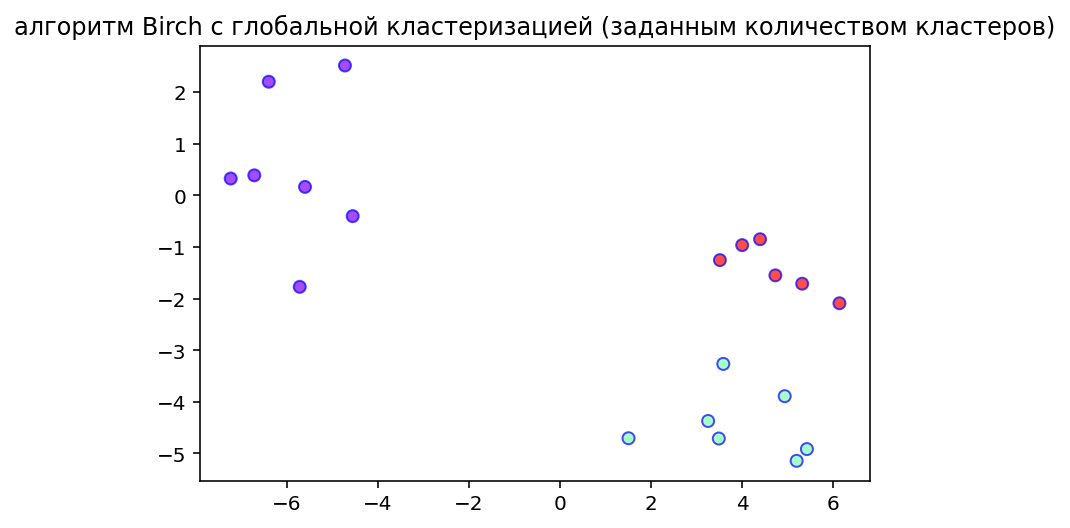

In [13]:
# построение графика результата
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size
print(f'количество кластеров = {n_clusters}')
# Creating a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.title('алгоритм Birch с глобальной кластеризацией (заданным количеством кластеров)')
plt.show()